In [1]:
import os
import re
import math
import numpy as np
import numpy.ma as ma
import pandas as pd
import seaborn as sn
import random 
import csv
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def splitData ():

    Data=pd.read_csv('Tweets.csv', sep=',',header=None)
    #replace class name with numbers (easier to sort)
    Data = Data.replace('neutral',0)
    Data = Data.replace('positive',1)
    Data = Data.replace('negative',-1)
    #sorting Data
    Data = Data.loc[1:,:]
    Data = Data.sort_values(0)
    print(Data.shape)
    
    #seperating all the classes from data
    neg=0
    neut=0
    pos=0
    
    for i in range(Data.shape[0]):

        if(Data.iloc[i,0] == -1):
            neg+=1
            neut+=1
            pos+=1

        if(Data.iloc[i,0] == 0):
            neut+=1
            pos+=1

        if(Data.iloc[i,0] == 1):
            pos+=1
            
    negData = Data.iloc[0:neg,:]
    neutData = Data.iloc[neg:neut,:]
    posData = Data.iloc[neut:pos,:]

    #spliting each class in 80% and 20% for training and testing
    negindex = round(negData.shape[0]*80/100)
    neutindex = round(neutData.shape[0]*80/100)
    posindex = round(posData.shape[0]*80/100)
    
    
    TrainNegData = negData.iloc[0:negindex,:]
    TrainNeutData = neutData.iloc[0:neutindex,:]
    TrainPosData = posData.iloc[0:posindex,:]
    
    TrainData = pd.concat([TrainNegData,TrainNeutData],axis=0)
    TrainData = pd.concat([TrainData,TrainPosData],axis=0)

    
    TestNegData = negData.iloc[negindex:,:]
    TestNeutData = neutData.iloc[neutindex:,:]
    TestPosData = posData.iloc[posindex:,:]
    
    TestData = pd.concat([TestNegData,TestNeutData],axis=0)
    TestData = pd.concat([TestData,TestPosData],axis=0)


    return TrainData, TestData

In [3]:
#trainData, testData = splitData()
#trainData.to_csv('trainData.csv', sep=',')
#testData.to_csv('testData.csv', sep=',')

trainData=pd.read_csv('trainData.csv', sep=',')
testData=pd.read_csv('testData.csv', sep=',')

print(trainData.shape)
print(testData.shape)
print(testData.head())




(11711, 3)
(2929, 3)
   Unnamed: 0  0                                                  1
0        3781 -1  @united why do you hire POS pilots? Thanks for...
1        4401 -1  @VirginAmerica why are your first fares in May...
2        3779 -1  @USAirways the disappointment was not the bag ...
3        3778 -1  @united - with airport self checkin your only ...
4        3777 -1  @united the wifi in the ewr lounge reminds me ...


In [4]:
def cleanData (Data):

    b = "!@&*~`<>#$',.?-_/\*%=+|;:(){}1234567890"
    stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", 
         "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this",
         "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have","has", "had", "having", "do", "does", "did", "doing",
         "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",
         "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out","on", "off", "over", "under", "again",
         "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most","other", "some",
         "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now",
         "southwestair", "usairways", "jetblue", "united", "hold", "flight", "customer", "get", "service", "us", "americanair", "hours", "hour", "time", "im",
         "thanks"]

    newData = Data 
    #clean all the tweets one by one and save them in newData
    for i in range(Data.shape[0]):
        
        row = Data.iloc[i,1]
        #print(row)
        #print(i)
        row = row.lower()
        #print('*************')

        for char in b:
            row = row.replace(char,"")
        row = row.replace('"',"")
        #help taken from internet for removal of stop words
        tweet = row.split()
        resultwords  = [word for word in tweet if word.lower() not in stopwords]
        row = ' '.join(resultwords)

        #print(row)
        #print('********************************************************************************************************************')
        newData.iloc[i,1] = row

    print('cleaned Data =',newData.shape[0])

    return newData

In [5]:
def getvocabulorymatrix (Data):

    singlestring = ''
    
    print(Data.shape[0])
    
    for i in range(Data.shape[0]):

        singlestring = singlestring + ' '+ Data.iloc[i,1]

    str_list = singlestring.split()
    unique_words = set(str_list) 

    print('No of total words in data =',len(str_list))
    print('No of unique words in data =',len(unique_words))

    #creates vocabulory matrix
    vocabulory = pd.DataFrame(list(unique_words))
    print(vocabulory.head(10))
    
    #add new column for each tweet
    for t_num in range(Data.shape[0]+1):
        if(t_num >0):
            vocabulory[t_num] = 0

    print(vocabulory.shape)
    
    return vocabulory

In [6]:
def VocabFreqMatrix (Data):

    newData = cleanData(Data)

    vocabulory = getvocabulorymatrix(newData)

    #save vocabulory for later use in csv file
    #vocabulory.to_csv('data.csv', sep='\t')

    vocab = vocabulory.loc[:,0]
    #converts pandas vocabulory to numpy array
    vocab = vocab.to_numpy()

    for t_num in range(newData.shape[0]):

        tweet = newData.iloc[t_num,1]
        #split tweet into words
        str_list = tweet.split()
        tweet_words = set(str_list)


        #put count of every word in each tweet at its column added earlier
        for word in tweet_words : 

            #find that word in vocabulory to add its count
            arr_index = np.where(vocab == word)
            ind = arr_index[0][0]
            #returns count of word in tweet
            vocabulory.iloc[ind,t_num+1] = str_list.count(word)

    print(vocabulory.head())
    
    return vocabulory

In [7]:
#TrainVocabFreqMatrix = VocabFreqMatrix(trainData.iloc[:,1:])
#TrainVocabFreqMatrix.to_csv('TrainVocabFreqMatrix.csv', sep=',')

TrainVocabFreqMatrix = pd.read_csv('TrainVocabFreqMatrix.csv', sep=',')
print(TrainVocabFreqMatrix.head())

   Unnamed: 0                  0  1  2  3  4  5  6  7  8  ...  11702  11703  \
0           0          inbaggage  0  0  0  0  0  0  0  0  ...      0      0   
1           1  httptcoxijifymvqp  0  0  0  0  0  0  0  0  ...      0      0   
2           2              sucks  0  0  0  0  0  0  0  0  ...      0      0   
3           3              usuck  0  0  0  0  0  0  0  0  ...      0      0   
4           4         personable  0  0  0  0  0  0  0  0  ...      0      0   

   11704  11705  11706  11707  11708  11709  11710  11711  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 11713 columns]


In [8]:
X = TrainVocabFreqMatrix.iloc[:,2:]
print(X.head())
Vocab = TrainVocabFreqMatrix.iloc[:,1]
Y = trainData.iloc[0:,1]
X = X.T
print(X.head())
print(X.shape)
print(Y.shape)
print(Y.head())
print(Vocab.head())

   1  2  3  4  5  6  7  8  9  10  ...  11702  11703  11704  11705  11706  \
0  0  0  0  0  0  0  0  0  0   0  ...      0      0      0      0      0   
1  0  0  0  0  0  0  0  0  0   0  ...      0      0      0      0      0   
2  0  0  0  0  0  0  0  0  0   0  ...      0      0      0      0      0   
3  0  0  0  0  0  0  0  0  0   0  ...      0      0      0      0      0   
4  0  0  0  0  0  0  0  0  0   0  ...      0      0      0      0      0   

   11707  11708  11709  11710  11711  
0      0      0      0      0      0  
1      0      0      0      0      0  
2      0      0      0      0      0  
3      0      0      0      0      0  
4      0      0      0      0      0  

[5 rows x 11711 columns]
   0      1      2      3      4      5      6      7      8      9      ...  \
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0

In [9]:
X = X.to_numpy()
Y = Y.to_numpy()

In [10]:
def priors(Y):

    neg=0
    neut=0
    pos=0

    for i in range(Y.shape[0]):

        if(Y[i] == -1):
            neg+=1
            neut+=1
            pos+=1

        if(Y[i] == 0):
            neut+=1
            pos+=1

        if(Y[i] == 1):
            pos+=1

    negTweets = neg
    nuetTweets = neut-neg
    posTweets =  pos-neut

    print('negative',negTweets,'neutral',nuetTweets,'positive',posTweets)


    priorNeg = negTweets/Y.shape[0]
    priorNeut = nuetTweets/Y.shape[0]
    priorPos = posTweets/Y.shape[0]

    priorNeg = np.log10(priorNeg)
    priorNeut = np.log10(priorNeut)
    priorPos = np.log10(priorPos)

    print('P(neg)',priorNeg,'P(neut)', priorNeut,'P(pos)',priorPos)

    return priorNeg,priorNeut,priorPos,neg,neut,pos

In [11]:
priorNeg,priorNeut,priorPos,neg,neut,pos = priors(Y)

negative 7342 neutral 2479 positive 1890
P(neg) -0.20277960080868335 P(neut) -0.6743174542088299 P(pos) -0.7921321768034072


In [12]:
#freq of every word in vocabulory in every class
print(X.shape)
freq_neg = np.sum(X[0:neg,:],axis=0)
freq_neut = np.sum(X[neg:neut,:],axis=0)
freq_pos = np.sum(X[neut:pos,:],axis=0)
print(np.sum(freq_neg))
print(np.sum(freq_neut))
print(np.sum(freq_pos))

(11711, 13011)
66681
17227
12980


In [13]:
#checking if smoothing is required for every class
def checkClassVocab(freq_neg, freq_neut, freq_pos):

    num=0
    for i in range(freq_neg.shape[0]):

        if(freq_neg[i]==0):
            num+=1

    print('No of vocab words with zero freq in negative class =',num)

    num=0
    for i in range(freq_neut.shape[0]):

        if(freq_neut[i]==0):
            num+=1

    print('No of vocab words with zero freq in neutral class =',num)

    num=0
    for i in range(freq_pos.shape[0]):

        if(freq_pos[i]==0):
            num+=1

    print('No of vocab words with zero freq in positive class =',num)

    return 

In [14]:
checkClassVocab(freq_neg, freq_neut, freq_pos)

No of vocab words with zero freq in negative class = 3796
No of vocab words with zero freq in neutral class = 8035
No of vocab words with zero freq in positive class = 9081


In [15]:
def likelihood (inputarray, vocabsize):

    #vocabsize
    totalwordsinclass = np.sum(inputarray)
    
    #applying add-1 smoothing
    inputarray = np.add(inputarray,1)
    inputarray = inputarray/(totalwordsinclass + vocabsize)  

    inputarray = np.log10(inputarray)

    return inputarray 

In [16]:
neg_likelihood = likelihood(freq_neg, X.shape[1])
neut_likelihood = likelihood(freq_neut, X.shape[1])
pos_likelihood = likelihood(freq_pos, X.shape[1])

In [17]:
def predict (likelihood, prior, vocab,cleanedTestData):

    probofAllTweets = np.empty((cleanedTestData.shape[0]))

    #converts pandas vocabulory to numpy array
    vocab = vocab.to_numpy()

    OOV=0
  
    for tweet_num in range(cleanedTestData.shape[0]):

        tweet = cleanedTestData.iloc[tweet_num,1]
        probofTweet = 0

        #split tweet into words
        str_list = tweet.split()
        tweet_words = set(str_list)

        #put count of every word in each tweet at its column added earlier
        for word in tweet_words: 

            #find that word in vocabulory to add its count
            try:
                arr_index = np.where(vocab == word)
                ind = arr_index[0][0]
                #returns count of word in tweet
                wordlikelihood = likelihood[ind]
                probofTweet = probofTweet+wordlikelihood
            except:
                OOV+=1
        
        probofTweet = probofTweet+prior
        probofAllTweets[tweet_num] = probofTweet
    print('No of out of vocab words =',OOV)  

    return probofAllTweets

In [18]:
print(testData.head())
cleanedTestData = cleanData(testData.iloc[:,1:])

prob_tweet_neg = predict(neg_likelihood, priorNeg, Vocab, cleanedTestData)
prob_tweet_neut = predict(neut_likelihood, priorNeut, Vocab, cleanedTestData)
prob_tweet_pos = predict(pos_likelihood, priorPos, Vocab, cleanedTestData)


   Unnamed: 0  0                                                  1
0        3781 -1  @united why do you hire POS pilots? Thanks for...
1        4401 -1  @VirginAmerica why are your first fares in May...
2        3779 -1  @USAirways the disappointment was not the bag ...
3        3778 -1  @united - with airport self checkin your only ...
4        3777 -1  @united the wifi in the ewr lounge reminds me ...
cleaned Data = 2929
No of out of vocab words = 1971
No of out of vocab words = 1971
No of out of vocab words = 1971


In [20]:
#concatenating all 3 probability arrays, to find max easily

prob_tweet_neg1 = prob_tweet_neg[:,np.newaxis]
prob_tweet_neut1 = prob_tweet_neut[:,np.newaxis]
prob_tweet_pos1 = prob_tweet_pos[:,np.newaxis]
print(prob_tweet_pos.shape)
prob_tweet_all_class = np.concatenate((prob_tweet_neg1,prob_tweet_neut1),axis=1)
prob_tweet_all_class = np.concatenate((prob_tweet_all_class,prob_tweet_pos1),axis=1)

print(prob_tweet_all_class[10:,:])

(2929,)
[[-27.65607364 -29.7104601  -33.15286269]
 [-48.37644767 -45.29291947 -45.10110055]
 [-34.73363065 -40.61778173 -39.76822592]
 ...
 [-28.66862503 -31.19232416 -27.7144707 ]
 [-10.46705984 -12.09478734 -11.34996488]
 [-17.33749512 -17.28404152 -17.66109691]]


In [22]:
#***************************************************************RESULTS ON TESTING DATA********************************************************************
def result (prob_tweet_all_class, testData):

    a = np.argmax(prob_tweet_all_class, axis=1)
    print(prob_tweet_all_class.shape)
    print(a.shape)

    TP0 = 0
    TP1 = 0
    TP2 = 0
    FP0 = 0
    FP1 = 0
    FP2 = 0
    FN0 = 0
    FN1 = 0
    FN2 = 0
    TN0 = 0
    TN1 = 0
    TN2 = 0

    testY = testData.iloc[:,1]
    print(testY.head())
    testY = testY.to_numpy()

    #index 0 represent negative (-1) class, 1 neutral (0) and 2 positive (1)
    for x in range (testY.shape[0]):

        if(a[x] ==0 ):
            if(testY[x]==-1):
                TP0=TP0+1

        if(a[x] ==0 ):
            if(testY[x]!=-1):
                FP0=FP0+1

        if(a[x] !=0 ):
            if(testY[x]==-1):
                FN0=FN0+1

        if(a[x] !=0 ):
            if(testY[x]!=-1):
                TN0=TN0+1

    for x in range (testY.shape[0]):

        if(a[x] ==1 ):
            if(testY[x]==0):
                TP1=TP1+1

        if(a[x] ==1 ):
            if(testY[x]!=0):
                FP1=FP1+1

        if(a[x] !=1 ):
            if(testY[x]==0):
                FN1=FN1+1

        if(a[x] !=1 ):
            if(testY[x]!=0):
                TN1=TN1+1

    for x in range (testY.shape[0]):

        if(a[x] ==2):
            if(testY[x]==1):
                TP2=TP2+1

        if(a[x] ==2):
            if(testY[x]!=1):
                FP2=FP2+1

        if(a[x] !=2):
            if(testY[x]==1):
                FN2=FN2+1

        if(a[x] !=2):
            if(testY[x]!=1):
                TN2=TN2+1

    P0 = TP0/(TP0+FP0)
    P1 = TP1/(TP1+FP1)
    P2 = TP2/(TP2+FP2)
    R0 = TP0/(TP0+FN0)
    R1 = TP1/(TP1+FN1)
    R2 = TP2/(TP2+FN2)

    MacroPrec = (P0+P1+P2)/3
    MacroRecall = (R0+R1+R2)/3

    MicroPrec = (TP0+TP1+TP2)/(TP0+TP1+TP2+FP0+FP1+FP2)
    MicroRecall = (TP0+TP1+TP2)/(TP0+TP1+TP2+FN0+FN1+FN2)

    MacroF1 = 2*((MacroPrec*MacroRecall)/(MacroPrec+MacroRecall))
    MicroF1 = 2*((MicroPrec*MicroRecall)/(MicroPrec+MicroRecall))

    print('Precision of class 0 =', P0)
    print('Precision of class 1 =', P1)
    print('Precision of class 2 =', P2)
    print('Recall of class 0 =', R0)
    print('Recall of class 1 =', R1)
    print('Recall of class 2 =', R2)
    print('Macro Precision =',MacroPrec)
    print('Micro Precision =',MicroPrec)
    print('Macro Recall =',MacroRecall)
    print('Micro Recall =',MicroRecall)
    print('Macro F1 =', MacroF1)
    print('Micro F1 =', MicroF1)

    ConfMatrix0 = [[TP0,FP0],
                  [FN0,TN0]]

    df_CM0 = pd.DataFrame(ConfMatrix0, index = [i for i in "10"],
                  columns = [i for i in "10"])

    print('Confusion Matrix of Negative Class:\n',df_CM0)

    plt.figure(figsize = (5,5))
    sn.heatmap(df_CM0, annot=True)

    ConfMatrix1 = [[TP1,FP1],
                  [FN1,TN1]]

    df_CM1 = pd.DataFrame(ConfMatrix1, index = [i for i in "10"],
                  columns = [i for i in "10"])

    print('Confusion Matrix of Neutral Class:\n',df_CM1)

    plt.figure(figsize = (5,5))
    sn.heatmap(df_CM1, annot=True)

    ConfMatrix2 = [[TP2,FP2],
                  [FN2,TN2]]

    df_CM2 = pd.DataFrame(ConfMatrix2, index = [i for i in "10"],
                  columns = [i for i in "10"])

    print('Confusion Matrix of Positive Class:\n',df_CM2)

    plt.figure(figsize = (5,5))
    sn.heatmap(df_CM2, annot=True)
    
    return

(2929, 3)
(2929,)
0   -1
1   -1
2   -1
3   -1
4   -1
Name: 0, dtype: int64
Precision of class 0 = 0.747150696496412
Precision of class 1 = 0.6915254237288135
Precision of class 2 = 0.7886792452830189
Recall of class 0 = 0.9640522875816994
Recall of class 1 = 0.32903225806451614
Recall of class 2 = 0.4418604651162791
Macro Precision = 0.7424517885027481
Micro Precision = 0.7453055650392626
Macro Recall = 0.5783150035874982
Micro Recall = 0.7453055650392626
Macro F1 = 0.6501844402856138
Micro F1 = 0.7453055650392626
Confusion Matrix of Negative Class:
       1    0
1  1770  599
0    66  494
Confusion Matrix of Neutral Class:
      1     0
1  204    91
0  416  2218
Confusion Matrix of Positive Class:
      1     0
1  209    56
0  264  2400


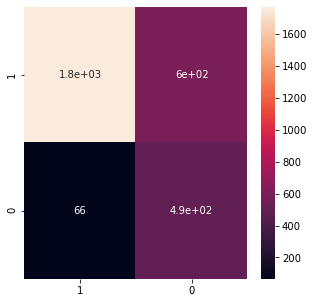

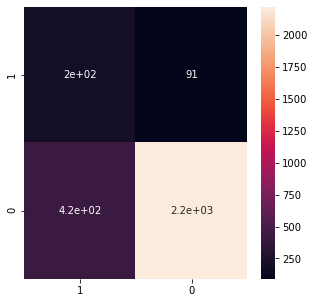

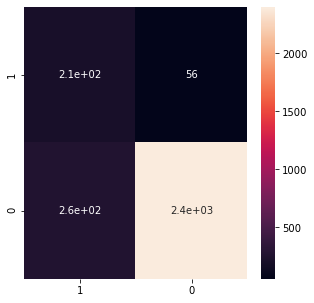

In [23]:
result (prob_tweet_all_class, testData)